# Notes: 
    
Contextual bandit

Reward is yards gained + touchdown + first down

Arms will be the play types 

Context will be set of features

Will need some sort of randomization component to not exploit plays 

need to find best play for each context

Evaluate against replay

Find real time plays that match prediction 

See how many are successful 

Success is within sd of yards gained, touchdown, first down

In [1]:
import numpy as np
import pandas as pd
import random
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Download and prep Data

In [2]:
#download data
!aws s3 cp s3://capstone-nfl-data/NFL_PBP_Data_2010_2022_original.parquet NFL_PBP_Data_2010_2022_original.parquet

download: s3://capstone-nfl-data/NFL_PBP_Data_2010_2022_original.parquet to ./NFL_PBP_Data_2010_2022_original.parquet


In [3]:
#Load Data
df = pd.read_parquet('NFL_PBP_Data_2010_2022_original.parquet', engine='pyarrow')
df.head()
print(df.shape)

(588078, 384)


In [4]:
df = df[df['play_type'].isin(['pass', 'run', 'punt', 'extra_point', 'field_goal']) ]
df = df[~(df['game_half'] == 'Overtime' )]

In [5]:
def transform_off_personnel(row):

   rb_count = 0
   te_count = 0
   wr_count = 0
   ol_count = 0
   dl_count = 0
   db_count = 0

   if not pd.isna(row['offense_personnel']):
       personnel = row['offense_personnel'].split(', ')
       for p in personnel:
           if p[2:4] == 'RB':
               rb_count = int(p[0])
           elif p[2:4] == 'TE':
                te_count = int(p[0])
           elif p[2:4] == 'WR':
                wr_count = int(p[0])
           elif p[2:4] == 'OL':
                ol_count = int(p[0])
           elif p[2:4] == 'DL':
                dl_count = int(p[0])
           elif p[2:4] == 'DB':
               db_count = int(p[0])

   return pd.Series([rb_count,te_count,wr_count,ol_count,dl_count, db_count])

df[['off_rb_count','off_te_count','off_wr_count','off_ol_count','off_dl_count', 'off_db_count']] = df.apply(transform_off_personnel, axis=1)

In [6]:
def transform_def_personnel(row):

   dl_count = 0
   db_count = 0
   lb_count = 0
   rb_count = 0
   wr_count = 0
   ol_count = 0
   
   if not pd.isna(row['defense_personnel']):
       personnel = row['defense_personnel'].split(', ')
       for p in personnel:
           if p[2:4] == 'LB':
                lb_count = int(p[0])
           elif p[2:4] == 'DL':
                dl_count = int(p[0])
           elif p[2:4] == 'DB':
                db_count = int(p[0])
           elif p[2:4] == 'WR':
                wr_count = int(p[0])
           elif p[2:4] == 'RB':
                rb_count = int(p[0])
           elif p[2:4] == 'OL':
                ol_count = int(p[0])
                
   return pd.Series([dl_count,db_count,lb_count,rb_count,wr_count,ol_count])

df[['def_dl_count','def_db_count','def_lb_count','def_rb_count','def_wr_count','def_ol_count']] = df.apply(transform_def_personnel, axis=1)

In [7]:
def PlayType_normalized(s):
  if s['play_type_nfl'] == 'PASS': 
    return 'PASS'
  elif s['play_type_nfl'] == 'RUSH': 
    return 'RUSH'
  else:
    return 'OTHER'
df['PlayType_normalized'] = df.apply(PlayType_normalized, axis=1)

In [8]:
df = df[~(df['PlayType_normalized'] == 'OTHER' )]

In [9]:
bins = [0,10,20,30,40,50,60,70,80,90,100]
df['yardline_binned'] = pd.cut(df['yardline_100'], bins)

# Light EDA

In [10]:
print(df.shape)

(392032, 398)


(array([ 90673.,      0.,      0., 105245.,      0.,      0.,  91066.,
             0.,      0., 105048.]),
 array([1.        , 1.29999995, 1.60000002, 1.89999998, 2.20000005,
        2.5       , 2.79999995, 3.0999999 , 3.4000001 , 3.70000005,
        4.        ]),
 <BarContainer object of 10 artists>)

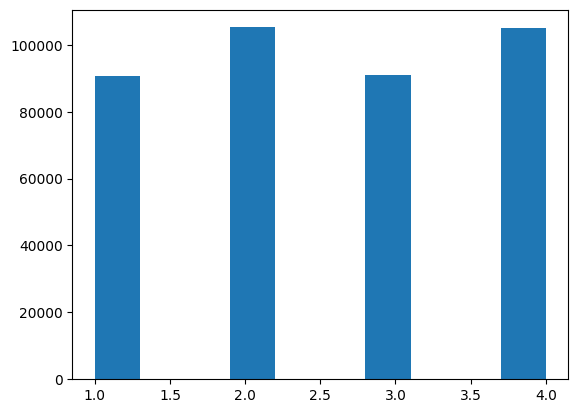

In [11]:
plt.hist(df[['qtr']])

(array([176069.,      0.,      0., 131372.,      0.,      0.,  78261.,
             0.,      0.,   6330.]),
 array([1.        , 1.29999995, 1.60000002, 1.89999998, 2.20000005,
        2.5       , 2.79999995, 3.0999999 , 3.4000001 , 3.70000005,
        4.        ]),
 <BarContainer object of 10 artists>)

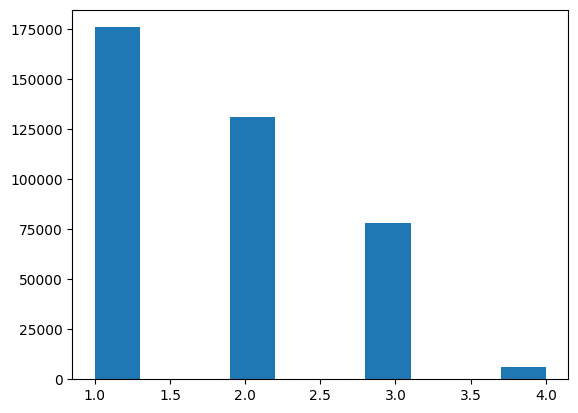

In [12]:
plt.hist(df[['down']])

(array([8.57220e+04, 2.65111e+05, 2.55280e+04, 1.22610e+04, 2.55800e+03,
        6.76000e+02, 1.45000e+02, 2.10000e+01, 7.00000e+00, 3.00000e+00]),
 array([ 1.        ,  5.9000001 , 10.80000019, 15.69999981, 20.60000038,
        25.5       , 30.39999962, 35.29999924, 40.20000076, 45.09999847,
        50.        ]),
 <BarContainer object of 10 artists>)

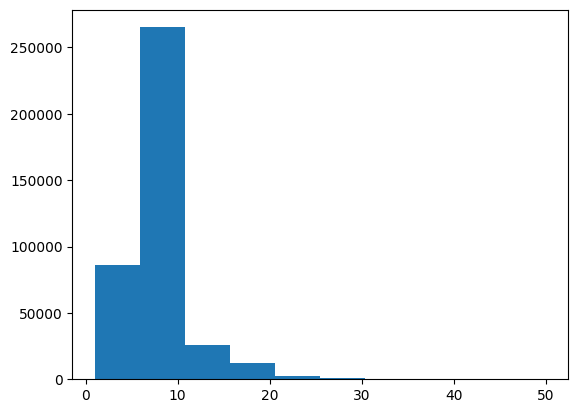

In [13]:
plt.hist(df[['ydstogo']])

In [14]:
context_qtr = df.qtr.unique()
context_down = df.down.unique()
context_yds = ['long', '10', '5', '1']
plays = ['PASS', 'RUSH'] 

print(context_qtr)
print(context_down)
print(context_yds)

[1. 2. 3. 4.]
[1. 2. 3. 4.]
['long', '10', '5', '1']


(array([265111.,      0.,      0.,      0.,      0.,  85722.,      0.,
             0.,      0.,  41199.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

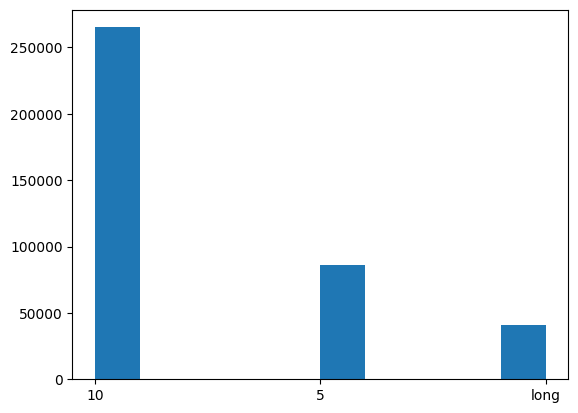

In [47]:
def ydstogo_binning(row): 
    if row.ydstogo > 10: 
        return 'long'
    elif row.ydstogo > 5: 
        return '10'
    else:
        return '5'




df['ydstogo_binned'] = df.apply(ydstogo_binning, axis=1)
plt.hist(df[['ydstogo_binned']])

(array([88756.,     0., 61626.,     0.,     0., 72833.,     0., 50737.,
            0., 60061.]),
 array([-2. , -1.6, -1.2, -0.8, -0.4,  0. ,  0.4,  0.8,  1.2,  1.6,  2. ]),
 <BarContainer object of 10 artists>)

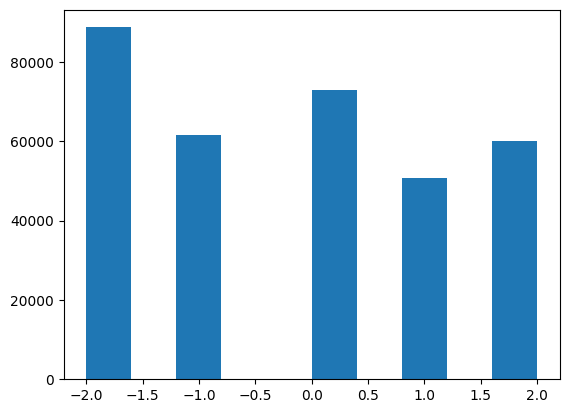

In [21]:
def score_diff_possession(row): 
    diff = row.score_differential
    if diff > 7: 
        return 2
    elif diff > 0 and diff < 7: 
        return 1
    elif diff == 0: 
        return 0
    elif diff < 0 and diff > -7: 
        return -1
    elif diff < -7: 
        return -2
    else:
        return None

df['poss_differential'] = df.apply(score_diff_possession, axis=1)
plt.hist(df.poss_differential)

(array([335795.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  56237.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

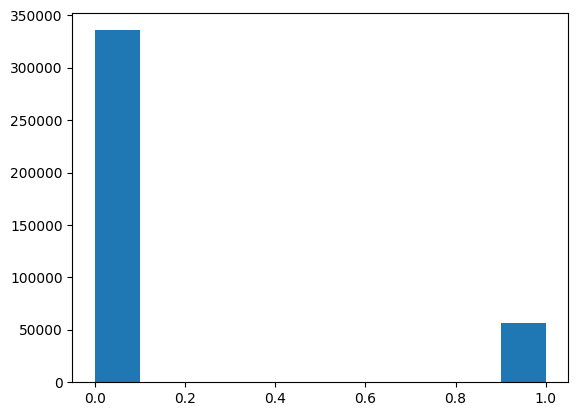

In [30]:
def red_zone(row): 
    if row.yardline_100 <= 20: 
        return 1
    else: 
        return 0

df['red_zone'] = df.apply(red_zone, axis=1)
plt.hist(df.red_zone)

In [63]:
df[['yards_gained']].describe()

,yards_gained
count,392032.000000
mean,6.001487
std,8.614878
min,-28.000000
25%,0.000000
50%,3.000000
75%,9.000000
max,99.000000


In [64]:
df[['touchdown']].describe()

,touchdown
count,392032.00000
mean,0.04142
std,0.19926
min,0.00000
25%,0.00000
50%,0.00000
75%,0.00000
max,1.00000


In [66]:
df[['first_down']].describe()

,first_down
count,392032.000000
mean,0.305383
std,0.460570
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


# Create Bandit

In [81]:
#Uses what actually happened to establish a baseline
class BaselineContextualBandit: 
    def __init__(self, arms, e): 
        self.arms = arms
        self.e = e
        self.n = 0
        self.mean_reward = 0
        self.context_rewards = {}
        self.context_n = {}
        self.match_count = 0
        self.success_count = 0 
        
    def get_defaults(self, red_zone, down, yds_to_go): 
            
            yards_gained = -1
            first_down = -1
            touchdown = -1
            
            
            if red_zone == 0: 

                if down == 1 and (yds_to_go == 'long' or yds_to_go == '10'): 
                    yards_gained = 0.9
                    first_down = 0.1
                    touchdown = 0
                elif down == 1 and yds_to_go == '5':
                    yards_gained = 0.5
                    first_down = 0.5
                    touchdown = 0
                elif down == 2 and yds_to_go == 'long': 
                    yards_gained = 0.8
                    first_down = 0.2
                    touchdown = 0
                elif down == 2 and yds_to_go == '10': 
                    yards_gained = 0.75
                    first_down = 0.25
                    touchdown = 0
                elif down == 2 and yds_to_go == '5': 
                    yards_gained = 0.5
                    first_down = 0.5
                    touchdown = 0
                elif down == 3 and yds_to_go == 'long': 
                    yards_gained = 0.5
                    first_down = 0.5
                    touchdown = 0
                elif down == 3 and yds_to_go == '10': 
                    yards_gained = 0.1
                    first_down = 0.9
                    touchdown = 0
                elif down == 3 and yds_to_go == '5': 
                    yards_gained = 0
                    first_down = 1
                    touchdown = 0
                elif down == 4 : 
                    yards_gained = 0
                    first_down = 1
                    touchdown = 0
            
            elif red_zone == 1: 
                
                if yds_to_go == 'long' or yds_to_go == '10': 
                    yards_gained = 0.5
                    first_down = 0
                    touchdown = 0.5
                elif yds_to_go == '5':
                    yards_gained = 0
                    first_down = 0
                    touchdown = 1
    
            return (yards_gained, first_down, touchdown)
    
    def get_reward_weights(self, quarter, down, yds_to_go, red_zone, poss_diff): 
        reward_weights = {}
        
        yards_gained = -1
        first_down = -1
        touchdown = -1
        
        if poss_diff == 2 and quarter == 1:
            
            if red_zone == 0 and down == 3 and yds_to_go == 10: 
                yards_gained = 0.25
                first_down = 0.75
                touchdown = 0
            
            elif red_zone == 1: 
                if yds_to_go == '10' or yds_to_go == 'long': 
                    yards_gained = 0.75
                    first_down = 0
                    touchdown = 0.25
                elif yds_to_go == '5':
                    yards_gained = 0.5
                    first_down = 0
                    touchdown = 0.5
            else: 
                yards_gained, first_down, touchdown = self.get_defaults(red_zone, down, yds_to_go) 
        
        elif poss_diff == -1 and quarter == 1: 
            if down == 3 and yds_to_go == 'long' and red_zone == 0: 
                yards_gained = 0.25
                first_down = 0.75
                touchdown = 0
            else: 
                yards_gained, first_down, touchdown = self.get_defaults(red_zone, down, yds_to_go) 
        
        elif poss_diff == -2 and quarter == 1: 
            if down == 2 and yds_to_go == '5' and red_zone == 0: 
                yards_gained = 0.8
                first_down = 0.2
                touchdown = 0
            elif down == 3 and yds_to_go == 'long' and red_zone == 0: 
                yards_gained = 0.2
                first_down = 0.8
                touchdown = 0
            else: 
                yards_gained, first_down, touchdown = self.get_defaults(red_zone, down, yds_to_go) 
        elif poss_diff == 2 and (quarter == 2 or quarter == 3):
            if down == 3 and yds_to_go == '10' and red_zone == 0:
                yards_gained = 0.25
                first_down = 0.75
                touchdown = 0
            elif red_zone == 1 and yds_to_go == '10':
                yards_gained = 0.75
                first_down = 0
                touchdown = 0.25
            elif red_zone == 1 and yds_to_go == '5':
                yards_gained = 0.5
                first_down = 0
                touchdown = 0.5
            else: 
                yards_gained, first_down, touchdown = self.get_defaults(red_zone, down, yds_to_go) 
        elif poss_diff == -1 and (quarter == 2 or quarter == 3): 
            if down == 1 and yds_to_go == '5' and red_zone == 0: 
                yards_gained = 0.9
                first_down = 0.1
                touchdown = 0
            elif down == 3 and yds_to_go == 'long' and red_zone == 0: 
                yards_gained = 0.25
                first_down = 0.75
                touchdown = 0
            elif red_zone == 1 and yds_to_go == 'long': 
                yards_gained = 0.25
                first_down = 0.5
                touchdown = 0.25
            else: 
                yards_gained, first_down, touchdown = self.get_defaults(red_zone, down, yds_to_go) 
        elif poss_diff == -2 and (quarter == 2 or quarter == 3): 
            if down == 1 and yds_to_go == '5' and red_zone == 0: 
                yards_gained = 0.9
                first_down = 0.1
                touchdown = 0
            elif down == 2 and yds_to_go == '5' and red_zone == 0: 
                yards_gained = 0.8
                first_down = 0.2
                touchdown = 0
            elif down == 3 and yds_to_go == 'long' and red_zone == 0:
                yards_gained = 0.2
                first_down = 0.8
                touchdown = 0
            elif down == 3 and yds_to_go == '10' and red_zone == 0: 
                yards_gained = 0.75
                first_down = 0.25
                touchdown = 0
            elif red_zone == 1 and yds_to_go == '10': 
                yards_gained = 0.25
                first_down = 0
                touchdown = 0.75
            else: 
                yards_gained, first_down, touchdown = self.get_defaults(red_zone, down, yds_to_go) 
        elif poss_diff == 2 and quarter == 4: 
            if down == 3 and yds_to_go == '10' and red_zone == 0: 
                yards_gained = 0.25
                first_down = 0.75
                touchdown = 0
            elif red_zone == 1 and (yds_to_go == '10' or yds_to_go == 'long'): 
                yards_gained = 1
                first_down = 0
                touchdown = 0
            elif red_zone == 1 and yds_to_go == '5':
                yards_gained = 0.5
                first_down = 0
                touchdown = 0.5
            else: 
                yards_gained, first_down, touchdown = self.get_defaults(red_zone, down, yds_to_go) 
        elif poss_diff == 1 and quarter == 4: 
            if red_zone == 1 and yds_to_go == 'long': 
                yards_gained = 0.25
                first_down = 0.5
                touchdown = 0.25
            else: 
                yards_gained, first_down, touchdown = self.get_defaults(red_zone, down, yds_to_go) 
        elif poss_diff == -1 and quarter == 4: 
            if down == 1 and yds_to_go == '5' and red_zone == 0: 
                yards_gained = 0.9
                first_down = 0.1
                touchdown = 0
            elif red_zone == 1 and yds_to_go == '10':
                yards_gained = 0.25
                first_down = 0.25
                touchdown = 0.75
            else:
                yards_gained, first_down, touchdown = self.get_defaults(red_zone, down, yds_to_go) 
        elif poss_diff == -2 and quarter == 4: 
            if down == 1 and (yds_to_go == '10' or yds_to_go == 'long') and red_zone == 0: 
                yards_gained = 1
                first_down = 0
                touchdown = 0
            elif down == 1 and yds_to_go == '5' and red_zone == 0: 
                yards_gained = 0.9
                first_down = 0.1
                touchdown = 0
            elif down == 2 and yds_to_go == 'long' and red_zone == 0: 
                yards_gained = 0.9
                first_down = 0.1
                touchdown = 0
            elif down == 2 and yds_to_go == '10' and red_zone == 0: 
                yards_gained = 0.8
                first_down = 0.2
                touchdown = 0
            elif down == 2 and yds_to_go == '5' and red_zone == 0: 
                yards_gained = 0.8
                first_down = 0.2
                touchdown = 0
            elif down == 3 and yds_to_go == 'long' and red_zone == 0: 
                yards_gained = 0.8
                first_down = 0.2
                touchdown = 0
            elif down == 3 and yds_to_go == '10' and red_zone == 0: 
                yards_gained = 0.75
                first_down = 0.25
                touchdown = 0
            elif red_zone == 1 and (yds_to_go == '10' or yds_to_go == 'long'): 
                yards_gained = 0
                first_down = 0
                touchdown = 1
            else: 
                yards_gained, first_down, touchdown = self.get_defaults(red_zone, down, yds_to_go) 
        else: 
                yards_gained, first_down, touchdown = self.get_defaults(red_zone, down, yds_to_go)         
    
        reward_weights['yards_gained'] = yards_gained
        reward_weights['first_down'] = first_down
        reward_weights['touchdown'] = touchdown
        return reward_weights
    
    def pull(self, context, row, weights):
        '''
        Use a row in the dataframe to update average rewards given context
        '''
        
        #Current rewards for context
        curr_context_rewards = self.context_rewards[context]
        
        #decide to use highest reward or try something new
        p = np.random.rand()
        if p < self.e: 
            selected_arm_idx = random.randint(0, len(self.arms) - 1)
        else: 
            selected_arm_idx = np.argmax(curr_context_rewards)
        
        #Get reward for decision
        reward = self.get_reward(self.arms[selected_arm_idx], context, row, weights)

        #Update counts
        self.n += 1
        self.context_n[context][selected_arm_idx] += 1
        
        #Update average rewards
        self.mean_reward = self.mean_reward + (reward - self.mean_reward) / self.n
        curr_context_rewards[selected_arm_idx] = curr_context_rewards[selected_arm_idx] + (reward - curr_context_rewards[selected_arm_idx]) / self.context_n[context][selected_arm_idx]
    
    def get_reward(self, arm, context, row, weights):
        '''
        Find expected reward for chosen arm in context
        '''
        yds_gained = np.random.normal(loc=6.0, scale = 8.6)
        touchdown_pct = np.random.normal(loc=0.04, scale = 0.20)
        first_down_pct = np.random.normal(loc=0.31, scale = 0.46)
        
        yds_gained_weight = weights['yards_gained']
        first_down_weight = weights['first_down']
        touchdown_weight = weights['touchdown']
        
        return (yds_gained_weight * (yds_gained / 100)) + (touchdown_weight * touchdown_pct) + (first_down_weight * first_down_pct)
    
    def train(self, df): 
        
        #Iterate over dataframe
        for index, row in df.iterrows():
            
            #Pull context
            context_key, weights = self.get_context_key(row)
            
            #Initialize rewards if this is new context
            if context_key not in self.context_rewards.keys(): 
                self.context_rewards[context_key] = np.zeros(len(self.arms))
                self.context_n[context_key] = np.zeros(len(self.arms))
            
            #Update rewards
            self.pull(context_key, row, weights)

    def predict(self, df): 
        '''
        Predict play for each context based on max reward
        '''
        predictions = []
        unseen_context = 0
        
        #Iterate over dataframe
        for index, row in df.iterrows(): 

            #Pull context
            context_key = self.get_context_key(row, test=1)[0]
            
            #Pull relevant rewards vector
            if context_key in self.context_rewards.keys(): 
                rewards = self.context_rewards[context_key]
            else: 
                rewards = [1, 0] 
                unseen_context += 1
            #find highest rewards
            max_idx = np.argmax(rewards)
            #Select associated arm with highest rewards
            arm = self.arms[max_idx] 
            #Add to predictions
            predictions.append(arm)
            
            if row.PlayType_normalized == arm:
                self.match_count += 1
                if row.success: 
                    self.success_count += 1
 

        print(unseen_context)
        return predictions

    def get_context_key(self, row, test = 0): 
        yds_to_go = row.ydstogo_binned
        red_zone = row.red_zone
        poss_diff = row.poss_differential
        down = row.down
        quarter = row.qtr
        
        context_key = str(quarter) + "_" + str(down) + "_" + str(yds_to_go) + "_" + str(poss_diff) + "_" + str(red_zone)
        
        if not test: 
            weights = self.get_reward_weights(quarter, down, yds_to_go, red_zone, poss_diff) 
        else: 
            weights = None
        
        return context_key, weights

    def get_evaluation_metrics(self):
        return self.match_count, self.success_count, self.success_count / self.match_count
    

In [52]:
# bandit = BaselineContextualBandit(['PASS', 'RUSH'], 0.1)

In [54]:
# for index, row in df.iterrows(): 
    
#     yds_to_go = row.ydstogo_binned
#     red_zone = row.red_zone
#     poss_diff = row.poss_differential
#     down = row.down
#     quarter = row.qtr
    
#     weights = bandit.get_reward_weights(quarter, down, yds_to_go, red_zone, poss_diff)
#     if weights['yards_gained'] < 0:
#         print("MISSING yards_gained: " + str(yds_to_go) + "|" + str(red_zone) + "|" + str(poss_diff) + "|" + str(down) + "|" + str(quarter))
    
#     if weights['first_down'] < 0:
#         print("MISSING first_down: " + str(yds_to_go) + "|" + str(red_zone) + "|" + str(poss_diff) + "|" + str(down) + "|" + str(quarter))
    
#     if weights['touchdown'] < 0:
#         print("MISSING touchdown: " + str(yds_to_go) + "|" + str(red_zone) + "|" + str(poss_diff) + "|" + str(down) + "|" + str(quarter))
#         break

In [40]:
# df_small = df.sample(10)
# display(df_small)

In [41]:
# bandit.train(df_small)

In [42]:
# print(bandit.context_rewards)
# print("==========")
# print(bandit.context_n)

In [57]:
def define_successful_play(row): 
    if row.yards_gained > 3 or row.touchdown or row.first_down:
        return 1
    else:
        return 0
    
df['success'] = df.apply(define_successful_play, axis=1)

In [58]:
train_df, test_df = train_test_split(df, test_size=.20)

In [82]:
bandit = BaselineContextualBandit(['PASS', 'RUSH'], 0.1)
bandit.train(train_df)

# print(bandit.context_rewards)
# print("==========")
# print(bandit.context_n)
# print("==========")
print(bandit.mean_reward)

0.12530812248224987


In [83]:
predictions = bandit.predict(test_df)

3


In [84]:
print(bandit.get_evaluation_metrics())

(38719, 20497, 0.5293783413827836)


# Next Steps

* ~~Evaluation of bandit~~
* ~~Move context pulling to helper function~~
* Create baseline bandit for formation calling
* Combine bandits into output production script